## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from PIL import Image
import cv2

### Getting the GMM code we had

In [ ]:
class multivariate_normal:
    """
    Custom implementation of the multivariate normal probability density function.
    This version is vectorized to handle a matrix of inputs.
    """
    def __init__(self, mean, cov):
        self.mean = np.array(mean)
        self.cov = np.array(cov)
        self.d = len(mean)
        
        try:
            # Add a small regularization value (jitter) to the diagonal for stability
            self.inv_cov = np.linalg.inv(self.cov + np.eye(self.d) * 1e-6)
            self.det_cov = np.linalg.det(self.cov + np.eye(self.d) * 1e-6)
        except np.linalg.LinAlgError:
            # Fallback for severe singularity
            self.inv_cov = np.linalg.inv(self.cov + np.eye(self.d) * 1e-4)
            self.det_cov = np.linalg.det(self.cov + np.eye(self.d) * 1e-4)

    def pdf(self, X):
        """
        Calculates the probability density function for each row in a matrix X.
        
        Args:
            X (np.ndarray): The data matrix of shape (n_samples, d).
            
        Returns:
            np.ndarray: An array of probability densities of shape (n_samples,).
        """
        X = np.array(X)
        
        # Ensure X is always 2D, even for single samples
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        # 1. Normalization constant (this is a scalar and remains the same)
        norm_const = 1.0 / np.sqrt(((2 * np.pi)**self.d) * self.det_cov)
        
        # 2. Vectorized Mahalanobis distance
        #    x_minus_mu will have shape (n_samples, d)
        x_minus_mu = X - self.mean
        
        # This is the key change. It calculates the Mahalanobis distance
        # for each row in x_minus_mu and returns an array of shape (n_samples,).
        mahalanobis_dist = np.sum((x_minus_mu @ self.inv_cov) * x_minus_mu, axis=1)
        
        # 3. Exponential term (this will be an array)
        exp_term = np.exp(-0.5 * mahalanobis_dist)
        
        # 4. Combine them to get the final PDF values
        result = norm_const * exp_term
        
        # If input was single sample, return scalar instead of array
        if result.shape[0] == 1:
            return result[0]
        return result

In [12]:
class GMM:

    def __init__(self, df, n_clusters=3, max_iters=1000, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol   # add tolerance
        self.random_state = 42
        
        # Store as NumPy array for clean math
        self.X = df.to_numpy() if hasattr(df, "to_numpy") else np.array(df)
        self.n_samples, self.n_features = self.X.shape

        self.means = []
        self.covariances = []
        self.mix_coeff = []
        self.resp = None
        self.likelihood = []
        self.resp_all_time = []
    def _add_watermark(self, ax):
        """Helper to add watermark to a plot."""
        ax.text(0.95, 0.95, "nidhish.jain",
                ha='right', va='top',
                transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        

    def __initialize_fit(self):
        np.random.seed(self.random_state)
        random_idx = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.means = self.X[random_idx]
        self.covariances = [np.eye(self.n_features) for _ in range(self.n_clusters)]
        self.mix_coeff = np.full(self.n_clusters, 1 / self.n_clusters)
    
    def get_log_likelihood(self):
        '''return the log likelihood of current model '''
        total_prob = np.zeros(self.n_samples)
        for k in range(self.n_clusters):
            mult_obj = multivariate_normal(mean= self.means[k],cov = self.covariances[k])
            # pdf = multivariate_normal.pdf(self.X, mean=self.means[k], cov=self.covariances[k])
            pdf = mult_obj.pdf(self.X)
            total_prob += self.mix_coeff[k] * pdf
        return np.sum(np.log(total_prob + 1e-12))

    
    def drawLikelihood(self):
        plt.plot(range(len(self.likelihood)), self.likelihood)
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        plt.title(f'Log-Likelihood vs Iterations for number of clusters = {self.n_clusters}')
        ax = plt.gca()
        self._add_watermark(ax)
        plt.show()
    
    def getLikelihood(self):
        return self.likelihood[-1] if self.likelihood else None

    def fit(self):
        self.__initialize_fit()
        likelihood = []

        for it in range(self.max_iters):
            # ---------- E-step ----------
            weighted_probs = np.zeros((self.n_samples, self.n_clusters))
            for k in range(self.n_clusters):
                distrib = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
                weighted_probs[:, k] = self.mix_coeff[k] * distrib.pdf(self.X)
            
            denominator = np.sum(weighted_probs, axis=1, keepdims=True)
            ## axis= 0 means we sum along each row so in  end we will have (col,) vector where each element will have the sum across cols
            ### axis = 1 means we sum along each column so in the end we will have (row,) vector where each element will have the sum across rows
            resp = weighted_probs / (denominator + 1e-12)  # Avoid division by zero
            self.resp = resp

            # ---------- M-step ----------
            N_k = np.sum(resp, axis=0)
            for k in range(self.n_clusters):
                # Update mean
                self.means[k] = np.sum(resp[:, k][:, np.newaxis] * self.X, axis=0) / N_k[k]
                ###resp[:, k] is of shape (n_samples,) so to do multiplication we do multiply it wth shape (n_samples, 1) so that it can be broadcasted to (n_samples, n_features)
                # Update covariance
                diff = self.X - self.means[k]
                reg_cov = 1e-6
                self.covariances[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k] + reg_cov * np.eye(self.n_features)
                # Update mixing coefficient
                self.covariances[k] += 1e-6 * np.eye(self.n_features)  # Regularization
                self.mix_coeff[k] = N_k[k] / self.n_samples

            # ---------- Likelihood ----------
            log_likelihood = self.get_log_likelihood()
            likelihood.append(log_likelihood)

            self.resp_all_time.append(self.resp)
            # ---------- Convergence Check ----------
            if it > 0 and abs(likelihood[-1] - likelihood[-2]) < self.tol:
                # stop early if improvement is below tolerance
                break

        self.likelihood = likelihood

    def getMembership(self):
        ### have to return probablity of each poi\
        # membership = np.zeros((self.n_samples, self.n_clusters))
        # for i in range(self.n_samples):
        #     for k in range(self.n_clusters):
        #         distrib = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
        #         membership[i, k] = self.mix_coeff[k] * distrib.pdf(self.X[i])
        #     membership[i, :] /= np.sum(membership[i, :])  # Normalize to get probabilities
        # return membership ### shouldnt we just return self.resp??
        return self.resp


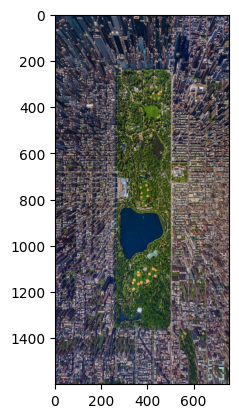

In [13]:
img1 = Image.open('images/satellite_1.png')
img2 = Image.open('images/satellite_2.png')
plt.imshow(img2)

In [14]:
def convert_to_df(image):
    img_arr = np.array(image)
    H, W, C = img_arr.shape   
    pixels = img_arr.reshape(-1, C) 
    # Generate coordinates
    rows, cols = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    coords = np.stack([rows.ravel(), cols.ravel()], axis=1)  # (H*W, 2)

    # Combine into DataFrame
    df = pd.DataFrame(
        np.hstack([coords, pixels]),
        columns=["row", "col", "R", "G", "B"]
    )

    return df



In [15]:
df1 = convert_to_df(img1)
print(df1.shape)

(767000, 5)


In [16]:

def get_segmented_image(img, membership, n_clusters=3):
    """
    img         : original PIL.Image (already opened)
    membership  : responsibilities (N x K)
    n_clusters  : number of clusters (default=3)
    """
    # Step 1: Assign cluster label
    labels = np.argmax(membership, axis=1)   # shape (N,)

    # Step 2: Pick fixed colors for each cluster (RGB)
    # You can adjust these colors for clarity
    cluster_colors = np.array([
        [255, 192, 203],   # orange -> vegetation
        [255, 0, 0],   # red -> Water
        [255, 255, 0]  # Yellow -> Land
    ], dtype=np.uint8)

    # Step 3: Map labels to colors
    segmented_flat = cluster_colors[labels]

    # Step 4: Reshape back to image
    H, W = img.size[::-1]   # careful: PIL gives (W,H)
    segmented_img = segmented_flat.reshape(H, W, 3)

    return segmented_img


In [17]:
def get_the_img_aarr(img1):
    df1 = convert_to_df(img1)
    x  = df1[['R','G','B']]
    print(x.head())
    gmm_1 = GMM(x,n_clusters = 3 , max_iters = 150)
    gmm_1.fit()
    # gmm_1.drawLikelihood()
    membership1  = gmm_1.getMembership()
    segmented_img1 = get_segmented_image(img1, membership1, n_clusters=3)
    first_arr = np.array(img1).astype(np.float32)/255.0
    seg_arr   = segmented_img1.astype(np.float32)/255.0

    alpha = 0.50
    overlay = alpha*first_arr + (1-alpha)*seg_arr
    return first_arr,seg_arr,overlay

    R   G   B
0  52  78  75
1  22  59  51
2  14  69  50
3  27  91  64
4  23  82  52


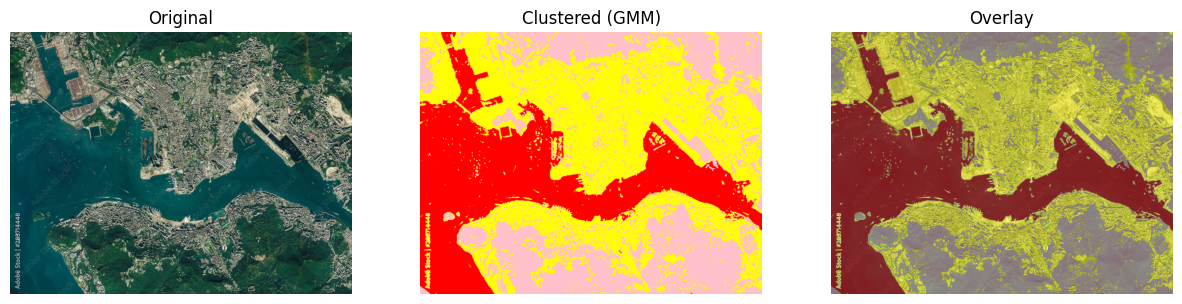

In [18]:
# df1 = convert_to_df(img1)
# x  = df1[['R','G','B']]
# print(x.head())
# gmm_1 = GMM(x,n_clusters = 3 , max_iters = 100)
# gmm_1.fit()
# # gmm_1.drawLikelihood()
# membership1  = gmm_1.getMembership()
# segmented_img1 = get_segmented_image(img1, membership1, n_clusters=3)
# first_arr = np.array(img1).astype(np.float32)/255.0
# seg_arr   = segmented_img1.astype(np.float32)/255.0

# alpha = 0.75
# overlay = alpha*first_arr + (1-alpha)*seg_arr
first_arr,seg_arr,overlay = get_the_img_aarr(img1)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(first_arr)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Clustered (GMM)")
plt.imshow(seg_arr)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")
plt.show()

    R   G   B
0  27  42  71
1  14  29  58
2  13  27  54
3  36  50  76
4  32  46  72


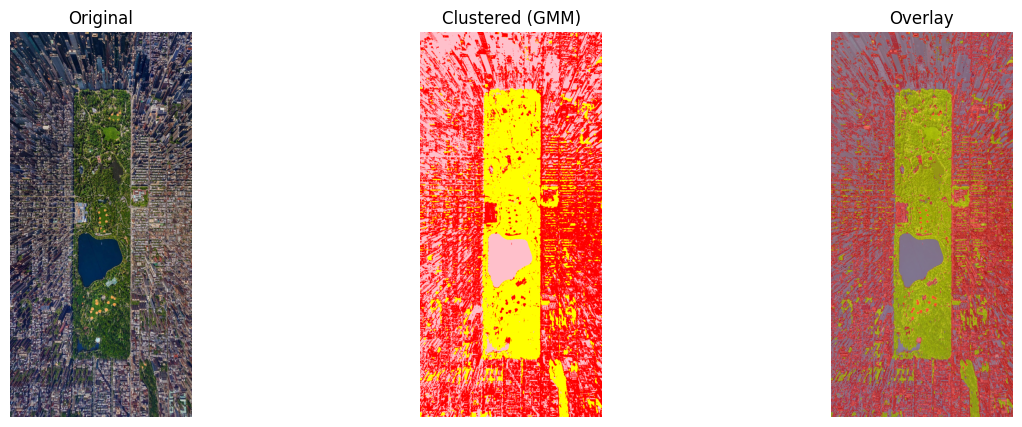

In [19]:
first_arr,seg_arr,overlay = get_the_img_aarr(img2)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(first_arr)
plt.axis("off")
plt.subplot(1,3,2)
plt.title("Clustered (GMM)")
plt.imshow(seg_arr)
plt.axis("off")
plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")
plt.show()


## 4.2 Video

In [20]:
def create_simple_video(img, max_iters=10):
    """
    Simple function to get segmented images and likelihoods for video creation
    """
    df = convert_to_df(img)
    x = df[['R','G','B']]
    gmm_obj = GMM(x, n_clusters=3, max_iters=max_iters)
    gmm_obj.fit()
    
    # Get all segmented images from each iteration
    segmented_images = []
    for resp in gmm_obj.resp_all_time:
        seg_img = get_segmented_image(img, resp, n_clusters=3)
        segmented_images.append(seg_img)
    
    return segmented_images, gmm_obj.likelihood

Creating video: video_for_img1.mp4
Video saved as: video_for_img1.mp4
Creating video: video_for_img2.mp4
Video saved as: video_for_img2.mp4


(<matplotlib.animation.FuncAnimation at 0x7bbde6b88340>,
 <Figure size 1500x500 with 3 Axes>)

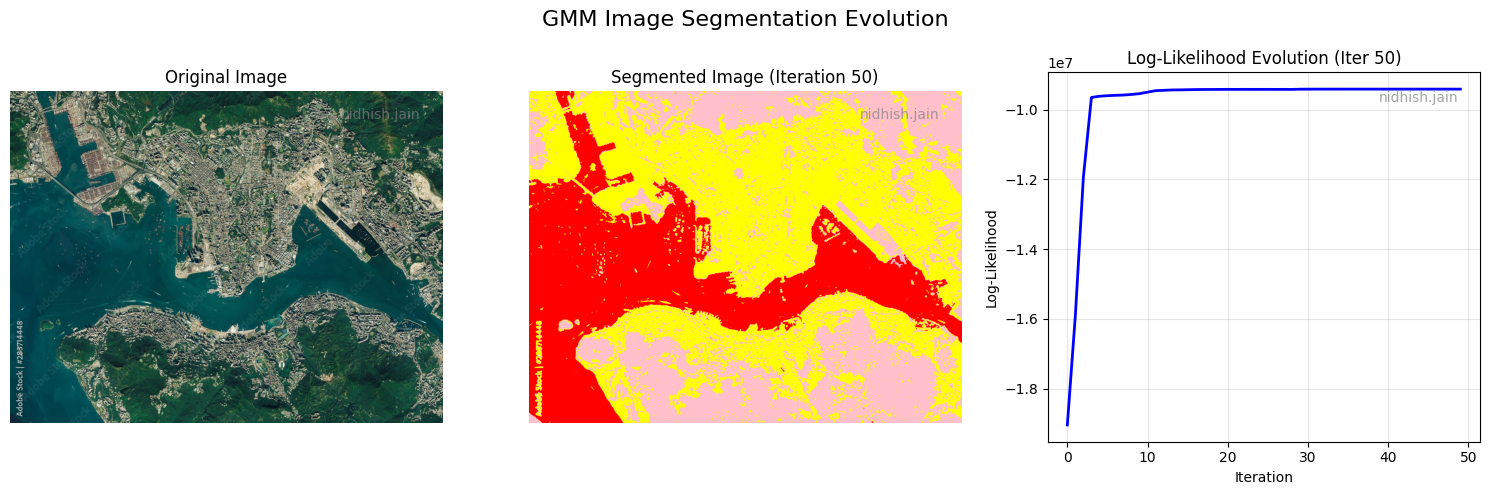

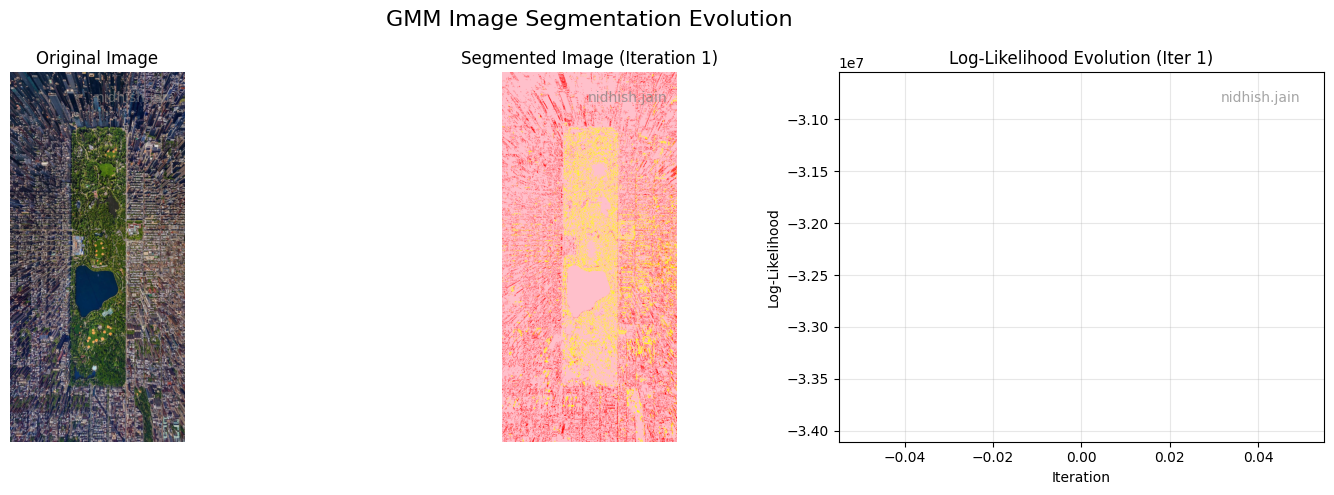

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Assuming your GMM class and helper functions are defined elsewhere

def create_video_with_panels(img, output_filename, frame_duration=0.75):
    """
    Create a video with three panels:
    - Left: Original image
    - Middle: Segmented image (evolving)
    - Right: Likelihood graph (growing)
    """
    # ... (all your code for GMM fitting and image generation remains the same) ...
    df = convert_to_df(img)
    x = df[['R','G','B']]
    gmm_obj = GMM(x, n_clusters=3, max_iters=50)
    gmm_obj.fit()
    all_time_resp = gmm_obj.resp_all_time
    likelihoods = gmm_obj.likelihood
    segmented_images = [get_segmented_image(img, resp, n_clusters=3) for resp in all_time_resp]
    original_img = np.array(img)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('GMM Image Segmentation Evolution', fontsize=16)
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.set_title('Segmented Image')
    ax2.axis('off')
    seg_display = ax2.imshow(segmented_images[0])
    ax3.set_title('Log-Likelihood Evolution')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Log-Likelihood')
    line, = ax3.plot([], [], 'b-', linewidth=2)
    ax3.grid(True, alpha=0.3)
    for ax in [ax1, ax2, ax3]:
        ax.text(0.95, 0.95, "nidhish.jain", ha='right', va='top', transform=ax.transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()
    
    def animate(frame):
        seg_display.set_array(segmented_images[frame])
        ax2.set_title(f'Segmented Image (Iteration {frame+1})')
        x_data = list(range(frame + 1))
        y_data = likelihoods[:frame + 1]
        line.set_data(x_data, y_data)
        ax3.relim()
        ax3.autoscale_view()
        ax3.set_title(f'Log-Likelihood Evolution (Iter {frame+1})')
        return [seg_display, line]

    num_frames = len(segmented_images)
    anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=int(frame_duration * 1000), blit=False)
    
    # --- RECOMMENDED CHANGE IS HERE ---
    # Ensure the output filename has the .mp4 extension
    if not output_filename.lower().endswith('.mp4'):
        output_filename += '.mp4'
    
    # Now, the rest of the saving code will work correctly
    print(f"Creating video: {output_filename}")
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1/frame_duration, metadata=dict(artist='nidhish.jain'), bitrate=1800)
    anim.save(output_filename, writer=writer)
    print(f"Video saved as: {output_filename}")
    
    return anim, fig

# You can now call the function without worrying about the extension
create_video_with_panels(img1, "video_for_img1")
create_video_with_panels(img2,"video_for_img2")

in image2 we observe that some buildings get mapped to water the simple reason being that the blue color of water is similar to the blue color of buildings in the image. So the gmm is not able to differentiate between the two and maps some buildings to water.